In [1]:
import ee
import pandas as pd
import numpy as np
from dfply import *


import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels.api as sm

import plotnine
from plotnine import *

import itertools
import difflib
import sys
import os
import requests
from tqdm.auto import tqdm
from pprint import pprint

In [2]:
# authenticate earthengine api
# ee.Authenticate()
ee.Initialize()

In [3]:
# change dir, append sys_path, and import custom moduls
sys.path.append('./')


from Modules.Modules import filter_exclude, get_img_df, compute_mean_ci
from Modules.Parallize_df import parallelize_dataframe

# might need reload modules as the code progrocessing
%load_ext autoreload
%autoreload 2

In [4]:
# get the admin shp
NCP_provinces = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_province_boundry")

# get the GAEZ pixel size
GAEZ_pix_scale = ee.Image("users/wangjinzhulala/Paper_3/03_GAEZ/GAEZ_2_Moisture_Annual_P_PET_1981_2010_Historical").projection().nominalScale().getInfo()

In [16]:
# read data
crop_yield_history_1975_2020 = pd.read_csv('./result_csv/crop_yield_history_1975_2020.csv')
GYGA_weighted_by_area_ratio = pd.read_csv('./result_csv/GYGA_weighted_by_area_ratio.csv')

GAEZ_attainable_t_ha_forced_with_GYGA = pd.read_pickle('./result_csv/GAEZ_attainable_t_ha_forced_with_GYGA.pkl')
GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul = pd.read_csv('./result_csv/GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul.csv')

GAEZ_actual_forced_with_Yearbook = pd.read_pickle('./result_csv/GAEZ_actual_forced_with_Yearbook.pkl')
GAEZ_actual_forced_with_Yearbook_weighted_mean_for_plot = pd.read_csv('./result_csv/GAEZ_actual_forced_with_Yearbook_weighted_mean_for_plot.csv')

GAEZ_actual_yield_propogated = pd.read_pickle('./result_csv/GAEZ_actual_yield_propogated.pkl')
GAEZ_actual_yield_propogated_area_weighted_mean_df = pd.read_csv('./result_csv/GAEZ_actual_yield_propogated_area_weighted_mean_df.csv')

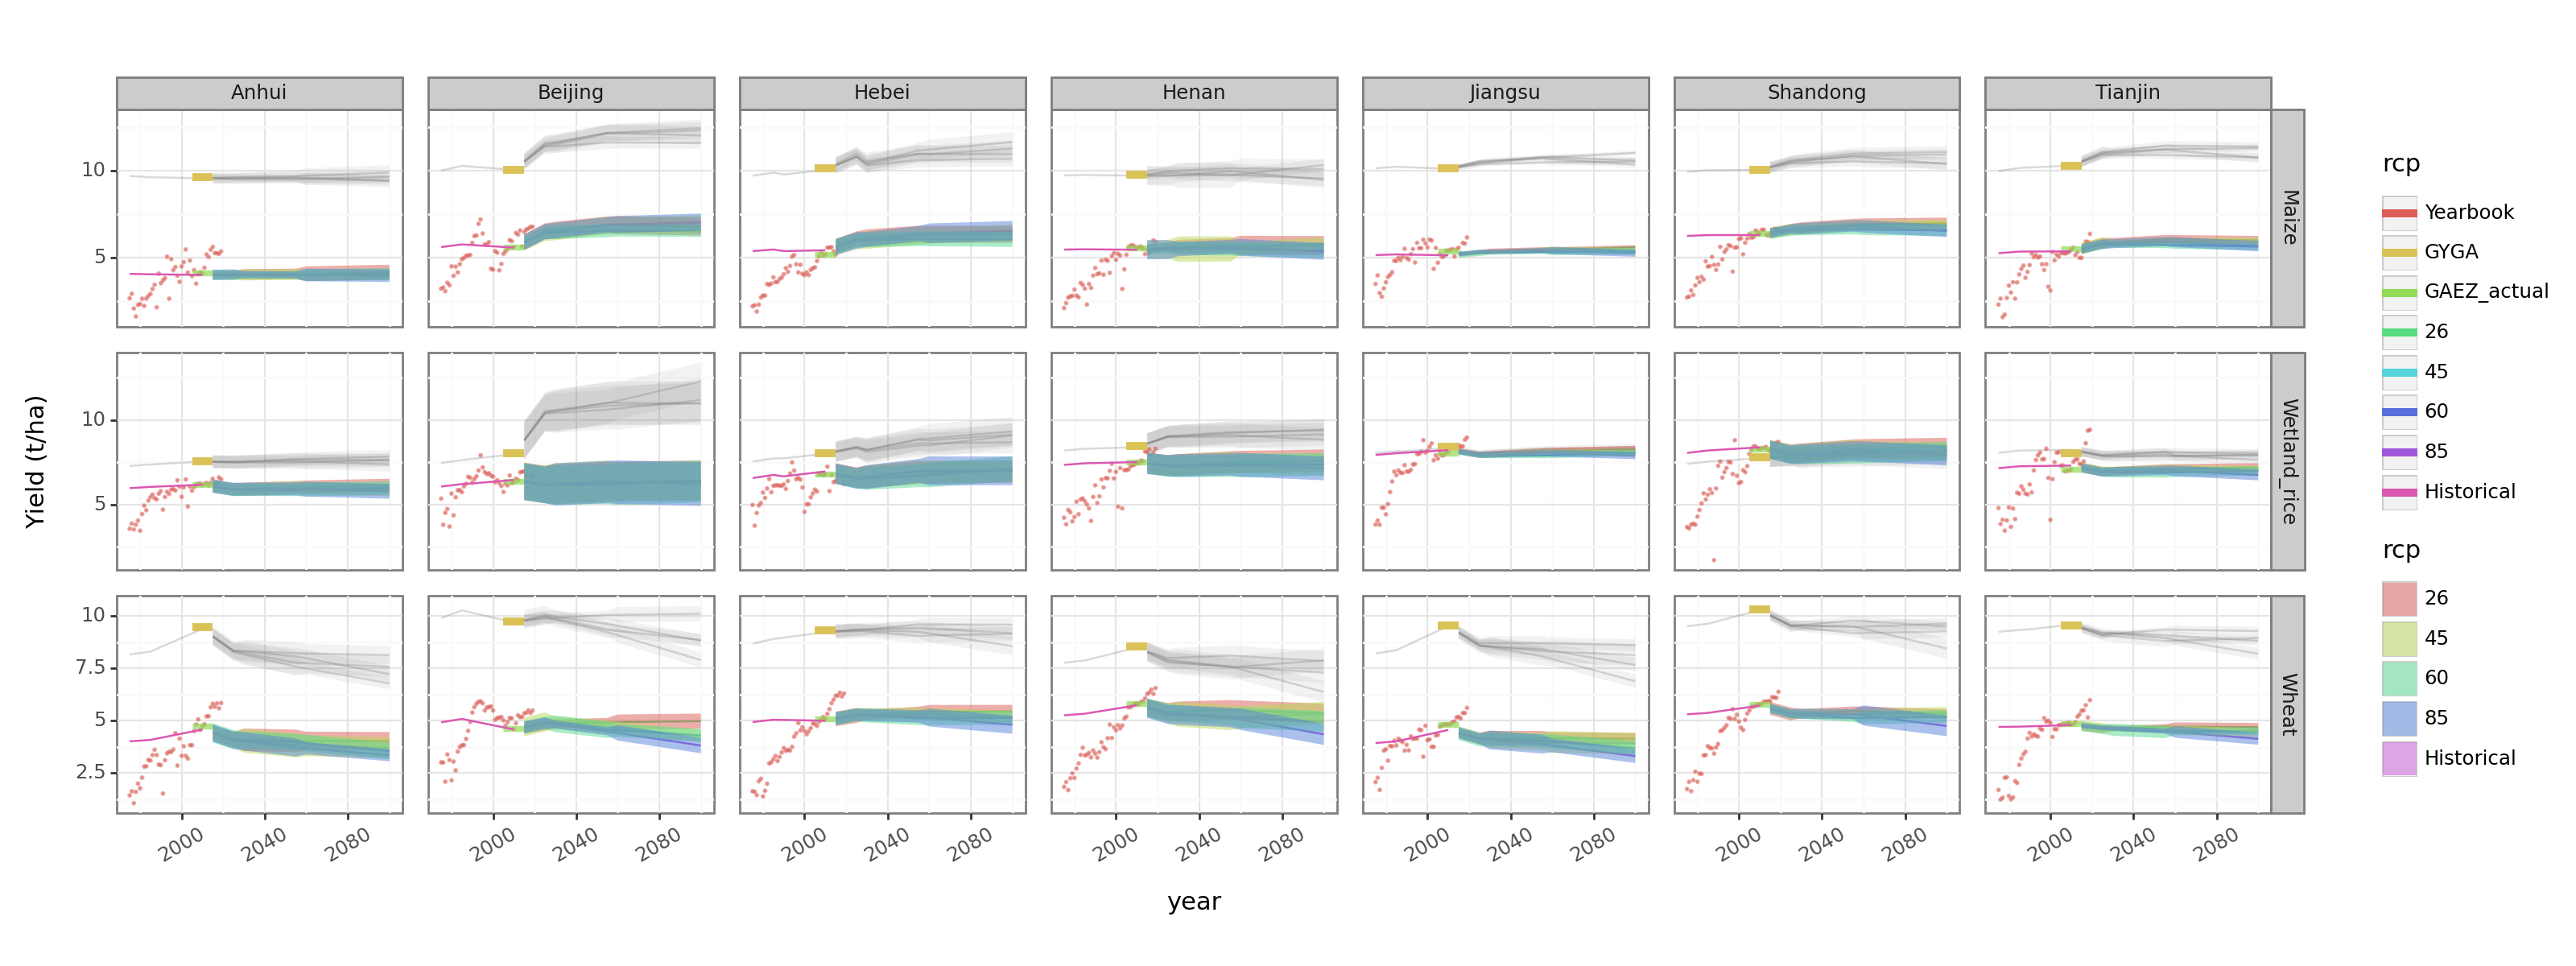

<Figure Size: (1600 x 600)>

In [6]:
# plot the GAEZ/Yearbook data
plotnine.options.figure_size = (16, 6)
plotnine.options.dpi = 100

(ggplot() +
 geom_line(GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul, aes('year','Mean Production',group='rcp'),alpha=0.3,color='grey') +
 geom_ribbon(GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul, aes(x='year',ymax='top',ymin='bot',group='rcp'),alpha=0.1,fill='grey') +
 geom_point(crop_yield_history_1975_2020, aes('year','Mean Production',color='rcp'),alpha=0.5,size=0.2) +
 geom_line(GYGA_weighted_by_area_ratio, aes('year','Mean Production',color='rcp'),size=2) +
 geom_line(GAEZ_actual_forced_with_Yearbook_weighted_mean_for_plot, aes('year','Mean Production',color='rcp'),size=1.5,alpha=0.7) +
 geom_line(GAEZ_actual_yield_propogated_area_weighted_mean_df, aes('year','Mean Production',color='rcp')) +
 geom_ribbon(GAEZ_actual_yield_propogated_area_weighted_mean_df, aes(x='year',ymax='top',ymin='bot',fill='rcp'),alpha=0.5) +
 facet_grid('crop~Province',scales='free') +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=30)) +
 ylab('Yield (t/ha)')
)

### Remove the historical climate change impacts from the yearbook crop yield records

#### Get the attainbale crop yield increase compared to 1975

In [7]:
# interpolated the attainbale of [1995,2000,2005...] to [1995,1996,1997...]
GAEZ_attainable_black_fill = GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul.copy()

# expande the year column: e.g., from 1995 to range(1995,2000)
GAEZ_attainable_black_fill['year_interpolate'] = GAEZ_attainable_black_fill['year'].apply(lambda x: list(range(x,x+5)) ,1)
GAEZ_attainable_black_fill_exp = GAEZ_attainable_black_fill.explode('year_interpolate') >> mask(X.year_interpolate<=2010)

# set the Mean Production of years e.g., [1996,...,1999] to 0
GAEZ_attainable_black_fill_exp.loc[GAEZ_attainable_black_fill_exp['year_interpolate']%5!=0,'Mean Production'] = np.nan
GAEZ_attainable_interpolated = GAEZ_attainable_black_fill_exp.sort_values(['crop','Province','year'])

# perform the interpolation: default is linear interpolation, which is what we need
GAEZ_attainable_interpolated['Mean Production'] = GAEZ_attainable_interpolated['Mean Production'].interpolate()
GAEZ_attainable_interpolated['year_interpolate'] = GAEZ_attainable_interpolated['year_interpolate'].astype('int')

GAEZ_attainable_interpolated = GAEZ_attainable_interpolated >> select(['crop','Province','rcp','year_interpolate','Mean Production']) >> rename(year='year_interpolate')

In [8]:
def compute_increase(row):
  crop = row['crop']
  province = row['Province']

  yield_1975 = GAEZ_attainable_interpolated >> mask(X.crop==crop,X.Province==province,X.year==1975)
  yield_1975 = yield_1975['Mean Production'].tolist()[0]

  return row['Mean Production'] - yield_1975

In [9]:
# compute the attainable yield increase compared to 1975
GAEZ_attainable_interpolated['increase_since_1975'] = GAEZ_attainable_interpolated.apply(lambda row:compute_increase(row),1)
GAEZ_attainable_interpolated = GAEZ_attainable_interpolated >> drop('Mean Production')

### Fit the historical crop yield using log/linear regressions

In [10]:
crop_yield_history_1975_2020.head()

,Province,year,Mean Production,crop,rcp
0,Beijing,2019,5.48530,Wheat,Yearbook
1,Beijing,2018,5.36743,Wheat,Yearbook
2,Beijing,2017,5.49235,Wheat,Yearbook
3,Beijing,2016,5.37393,Wheat,Yearbook
4,Beijing,2015,5.35289,Wheat,Yearbook


In [11]:
fit_yield_dfs = []
parameter_dfs = []
for province,crop in list(itertools.product(crop_yield_history_1975_2020['Province'].unique(),
                         crop_yield_history_1975_2020['crop'].unique())):

  stats = {}
  params = {}

  # Try use different date range [1975/1990] to 2010.

  for start_year in [1990,2000]:

    # filter df by [Province,Crop] and get x/y
    filter_df = crop_yield_history_1975_2020 >> mask(X.crop == crop,X.Province==province,X.year>=start_year) 

    x = filter_df['year'].values
    y = filter_df['Mean Production'].values

    # construct the regression
    pred_years = np.arange(start_year,2101)

    paras_log,_= scipy.optimize.curve_fit(lambda x,a,b: a*np.log(x) + b,  x,  y)
    y_pred_log = paras_log[0]*np.log(pred_years) + paras_log[1]

    paras_linear,_= scipy.optimize.curve_fit(lambda x,a,b: a*x + b,  x,  y)
    y_pred_linear = paras_linear[0]*pred_years + paras_linear[1]

    # store the prediction values
    stats['log_fit'] = y_pred_log
    stats['linear_fit'] = y_pred_linear

    stats['year'] = pred_years
    stats['crop'] = crop
    stats['Province'] = province
    stats['start_year'] = start_year

    stats_df = pd.DataFrame(stats)
    fit_yield_dfs.append(stats_df)

    # store regression parameters
    params['log_fit_a'] = [paras_log[0]]
    params['log_fit_b'] = [paras_log[1]]
    params['linear_fit_a'] = [paras_linear[0]]
    params['linear_fit_b'] = [paras_linear[1]]

    params['crop'] = [crop]
    params['Province'] = [province]

    params['start_year'] = [start_year]

    params_df = pd.DataFrame(params)
    parameter_dfs.append(params_df)

In [12]:
# get the fitting data
fit_df = pd.concat(fit_yield_dfs,ignore_index=True)
fit_df['fit_delta'] = fit_df['linear_fit'] - fit_df['log_fit']
fit_df['start_year'] = fit_df['start_year'].astype('category')

# get the regression parameters
parameter_df = pd.concat(parameter_dfs,ignore_index=True)

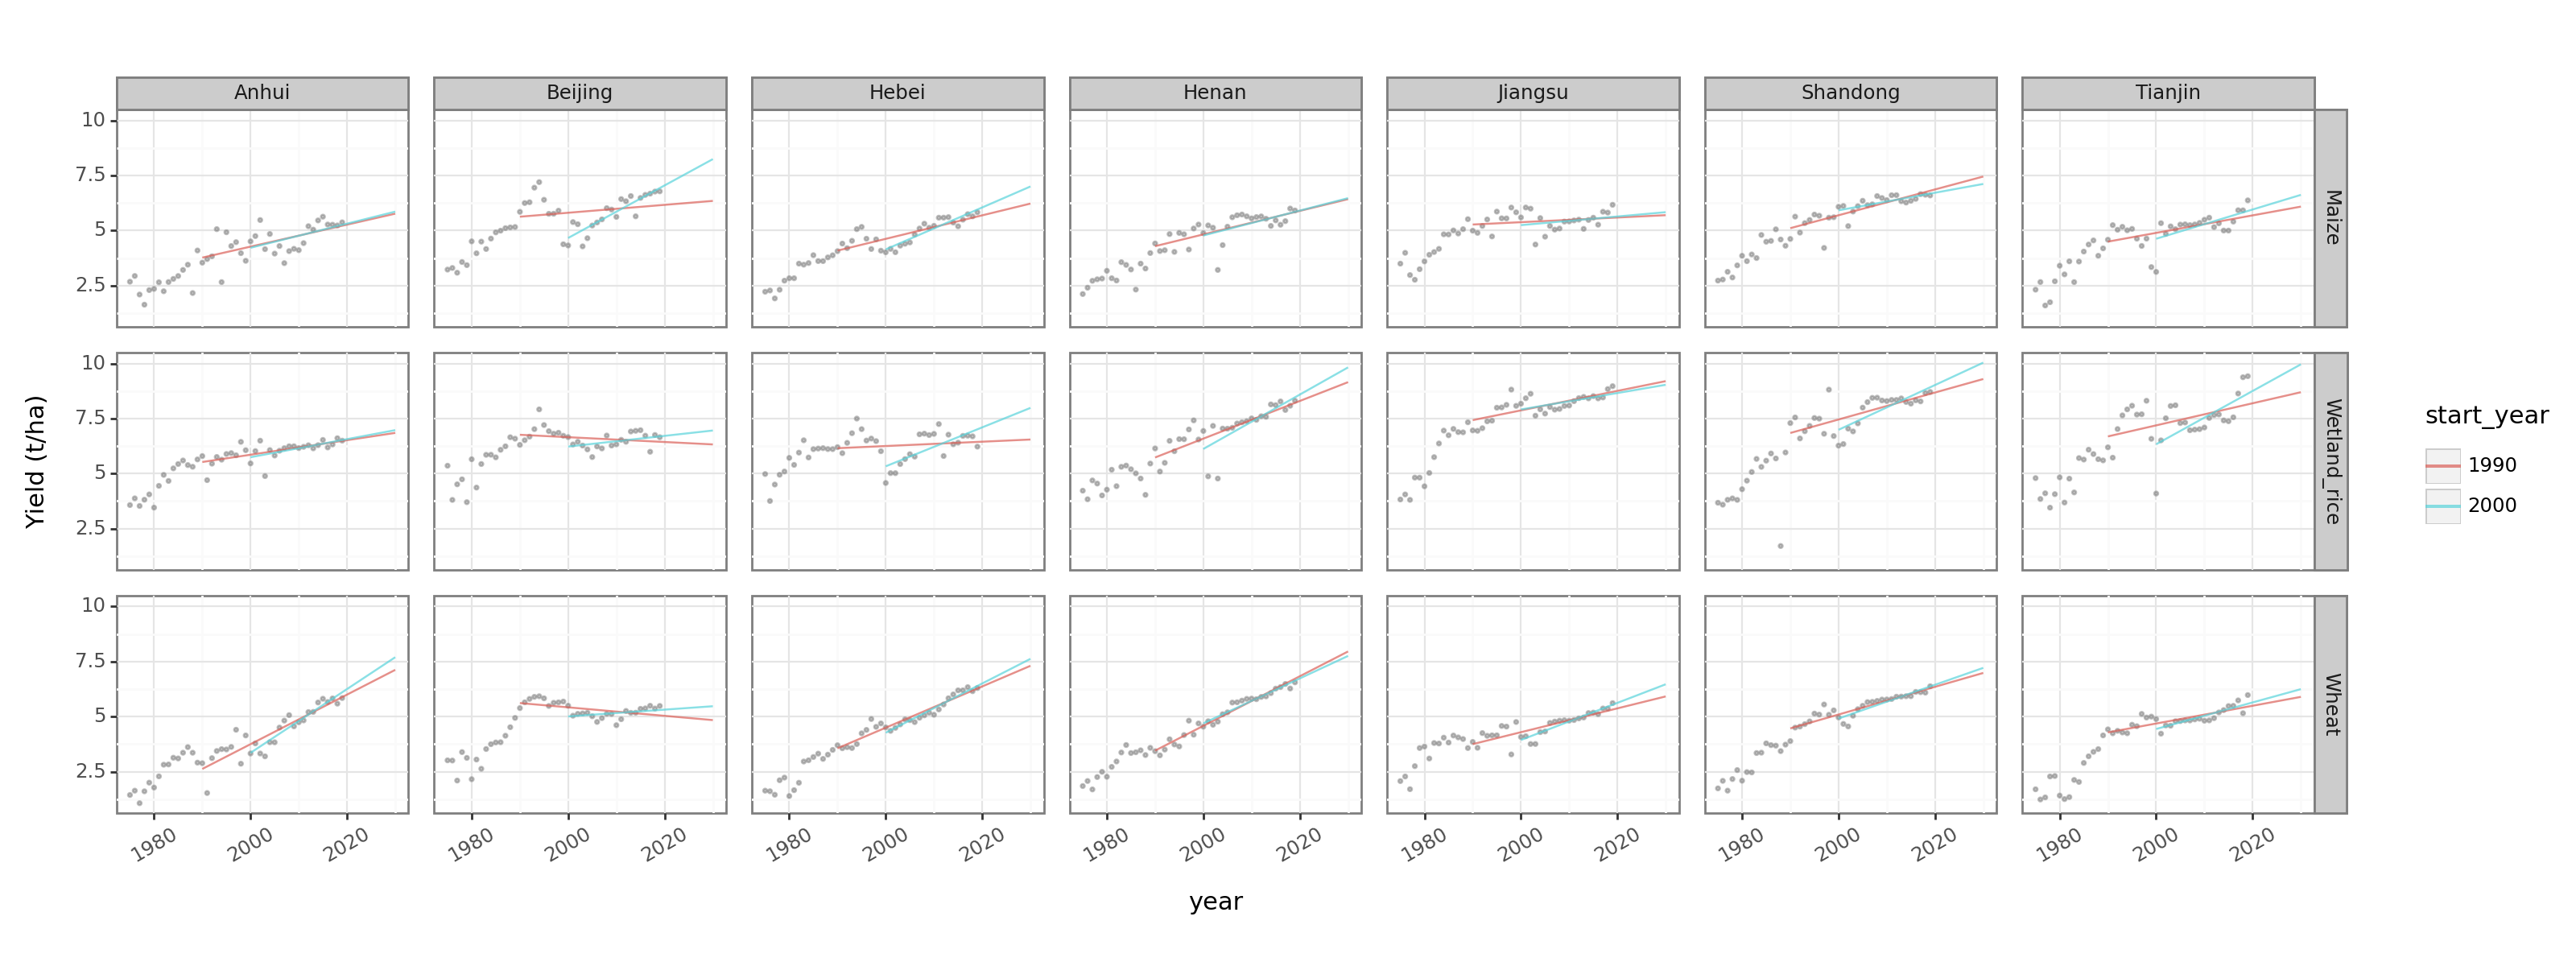

<Figure Size: (1600 x 600)>

In [13]:
# plot to see the difference of start_year on the prediction
# plot the subtraction
plotnine.options.figure_size = (16, 6)
plotnine.options.dpi = 100

g = (ggplot() +
 geom_point(crop_yield_history_1975_2020, aes('year','Mean Production'),color='grey',alpha=0.5,size=0.5) +
 geom_line(fit_df>>mask(X.year<=2030), aes('year','linear_fit',color='start_year'),alpha=0.7) +
 facet_grid('crop~Province') +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=30)) +
 scale_x_continuous(breaks = range(1900,2100,20)) +
 ylab('Yield (t/ha)')
)

g

In [15]:
g.save('../Figs/sup_16_yearbook_yield_fit_starting_1990_2000_.svg')

#### Observe the linear/log regression, sees that these two regression have not much of difference

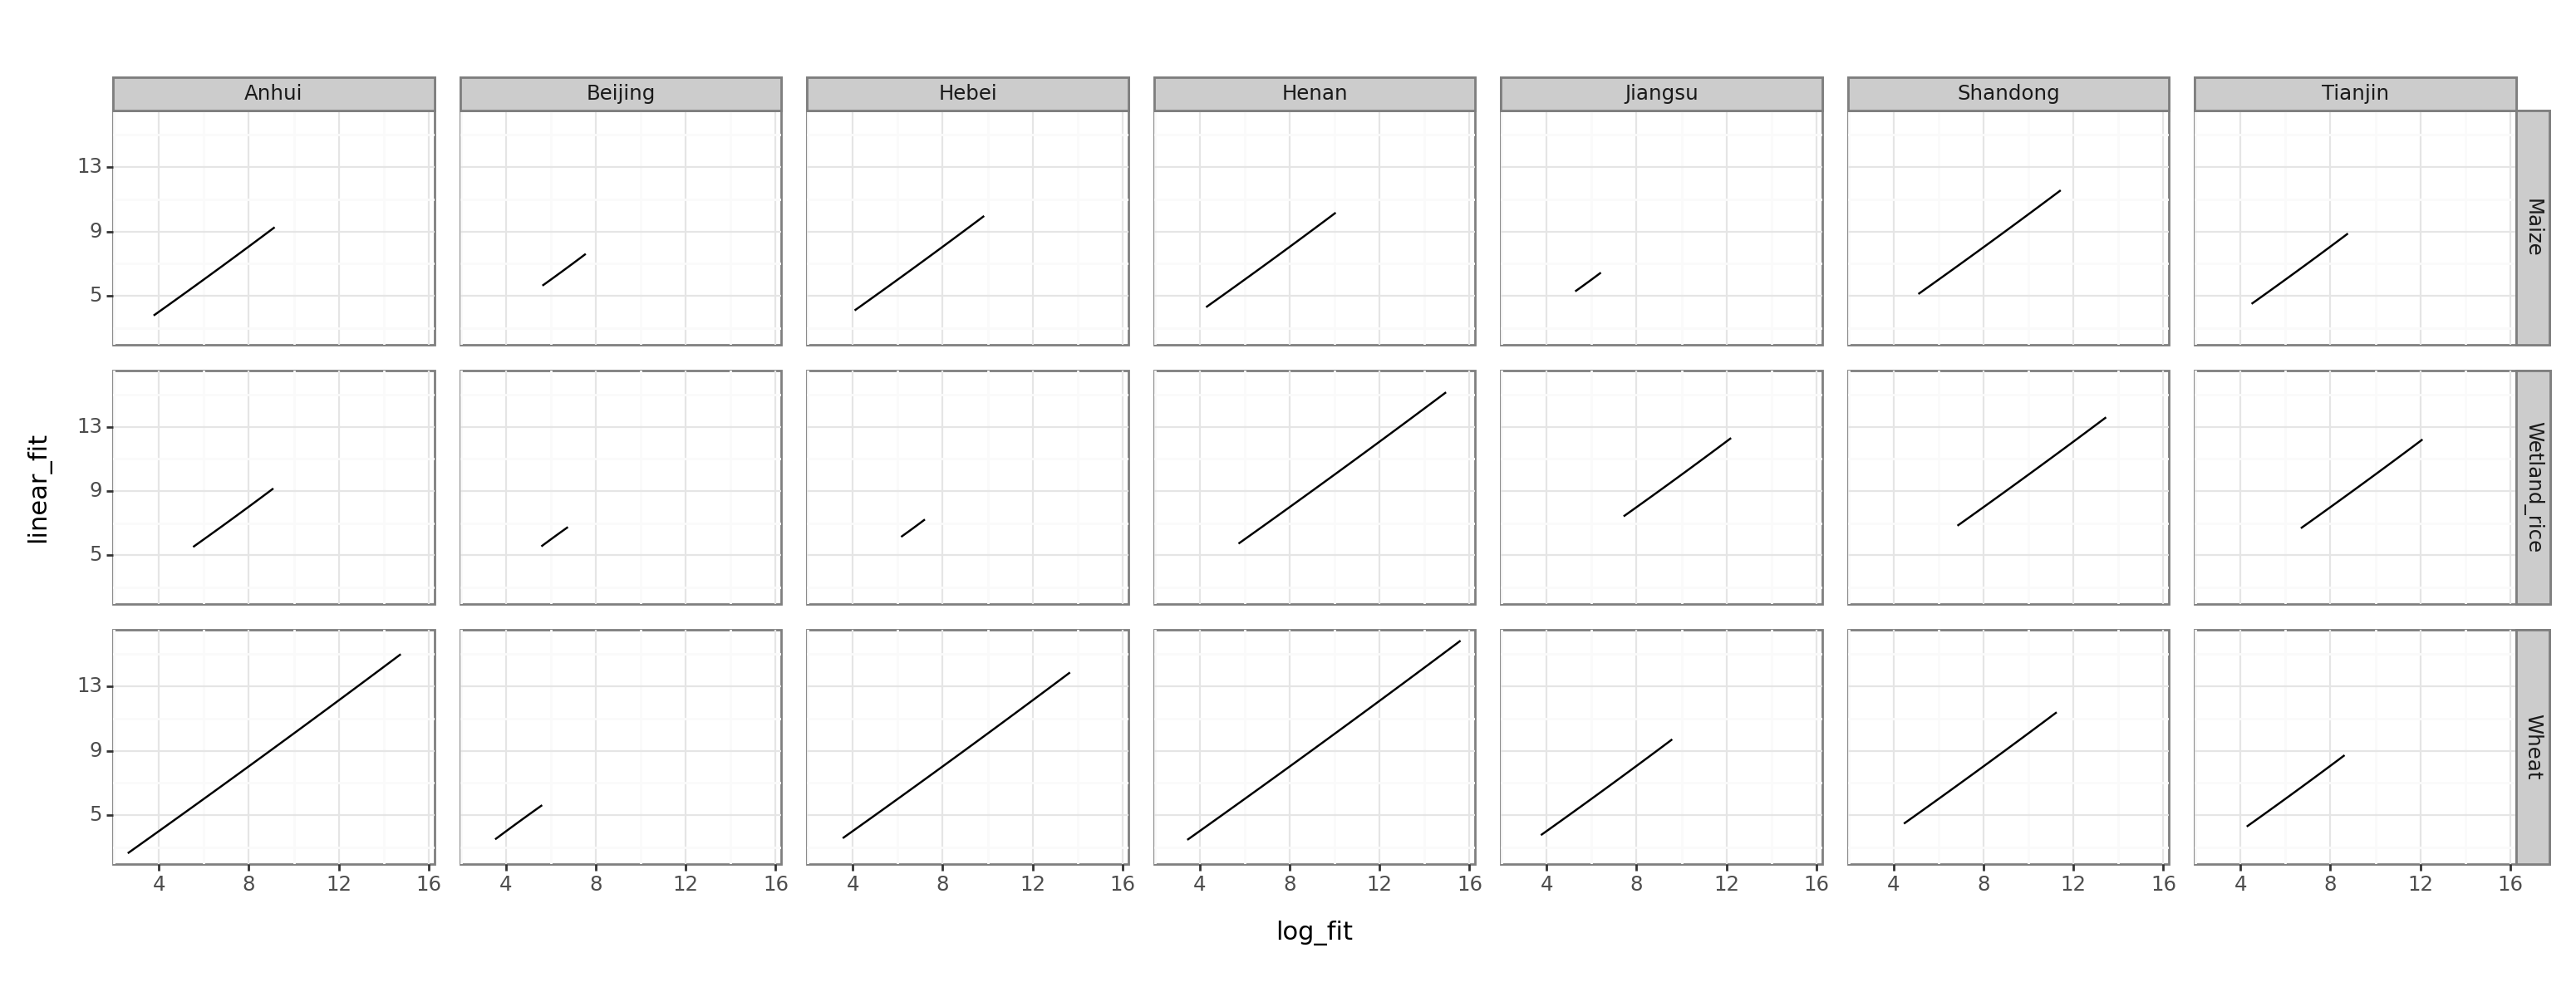

<Figure Size: (1550 x 600)>

In [17]:
# plot the GAEZ/Yearbook data
plotnine.options.figure_size = (15.5, 6)
plotnine.options.dpi = 100

(ggplot() +
 geom_line(fit_df>>mask(X.start_year==1990), aes('log_fit','linear_fit')) +
 facet_grid('crop~Province') +
 scale_y_continuous(breaks=range(1,20,4)) +
 theme_bw() 
)

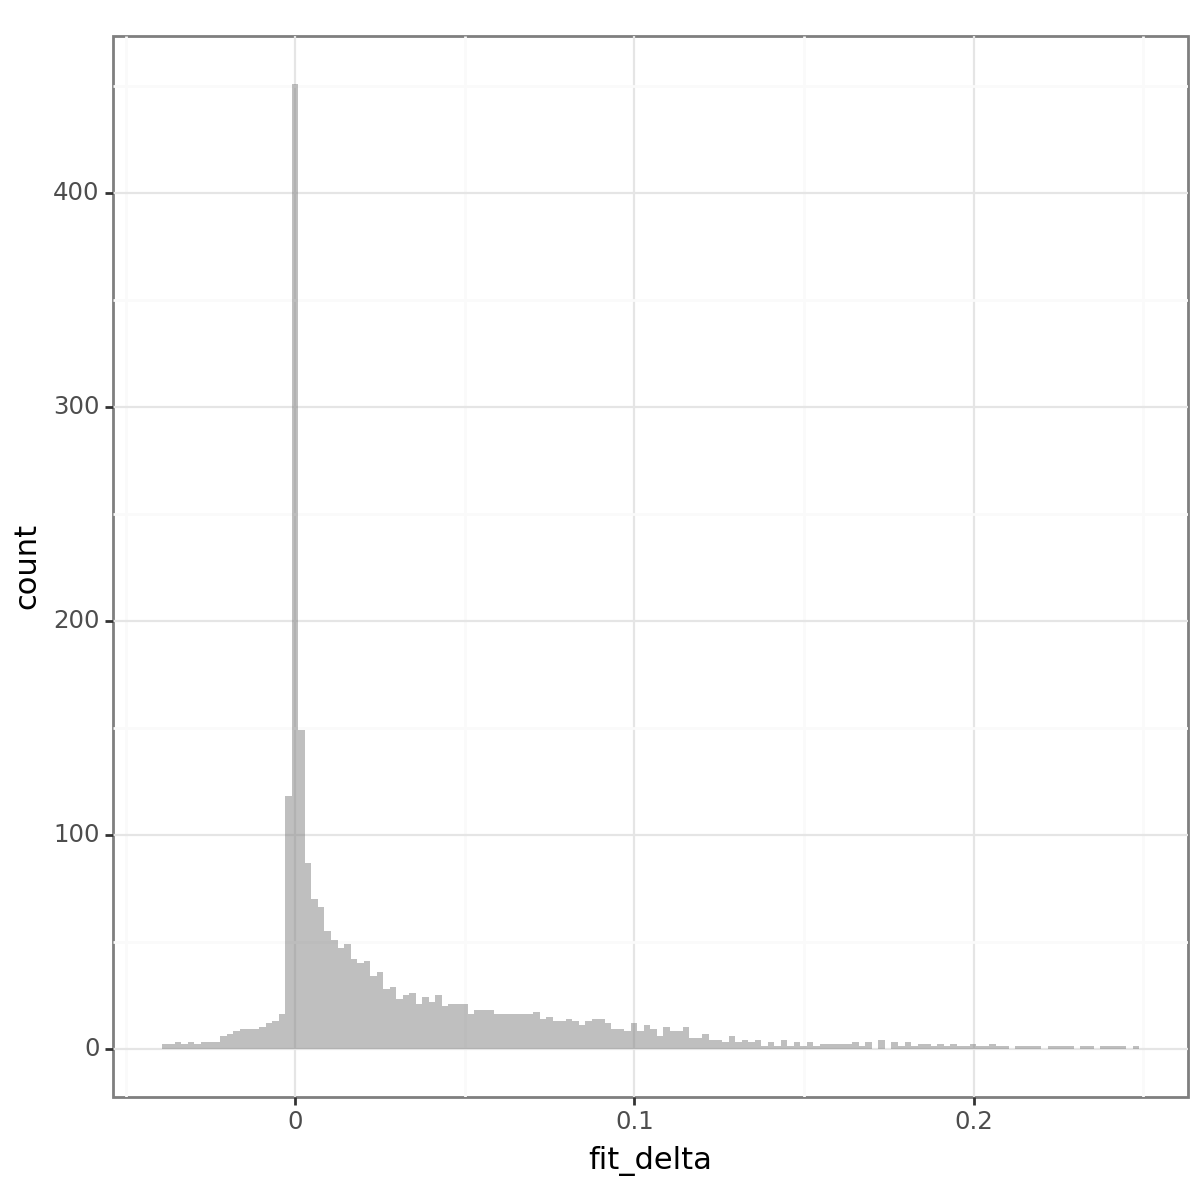

<Figure Size: (600 x 600)>

In [18]:
# plot the GAEZ/Yearbook data
plotnine.options.figure_size = (6, 6)
plotnine.options.dpi = 100

(ggplot() +
 geom_histogram(fit_df>>mask(X.start_year==1990), aes('fit_delta'),bins = 150,fill='grey',alpha=0.5) +
 theme_bw() 
)

### Use the Linear regression as Bussniess As Usuall (BAU), project the future crop yield

In [19]:
pred_dfs = []
for idx,df in crop_yield_history_1975_2020.groupby(['Province','crop']):
    
    # select the record gt 2000
    df = df >> mask(X.year >= 1990)

    # get data
    x = df['year']
    y = df['Mean Production']
    x = sm.add_constant(x)

    # construct the model
    mod = sm.OLS(y, x).fit()

    # make predictions
    pred_df = pd.DataFrame({'year':range(1990,2101)})
    pred_df = sm.add_constant(pred_df)

    rst_invertal = mod.get_prediction(pred_df).summary_frame(alpha=0.05)
    rst_invertal['Province'] = idx[0]
    rst_invertal['crop'] = idx[1]
    rst_invertal['year'] = pred_df['year']

    pred_dfs.append(rst_invertal)

# get the pred_df
fit_df = pd.concat(pred_dfs)\
    >> select(['Province','crop','year','mean','obs_ci_lower','obs_ci_upper']) \
    >> rename(linear_fit = X['mean'])

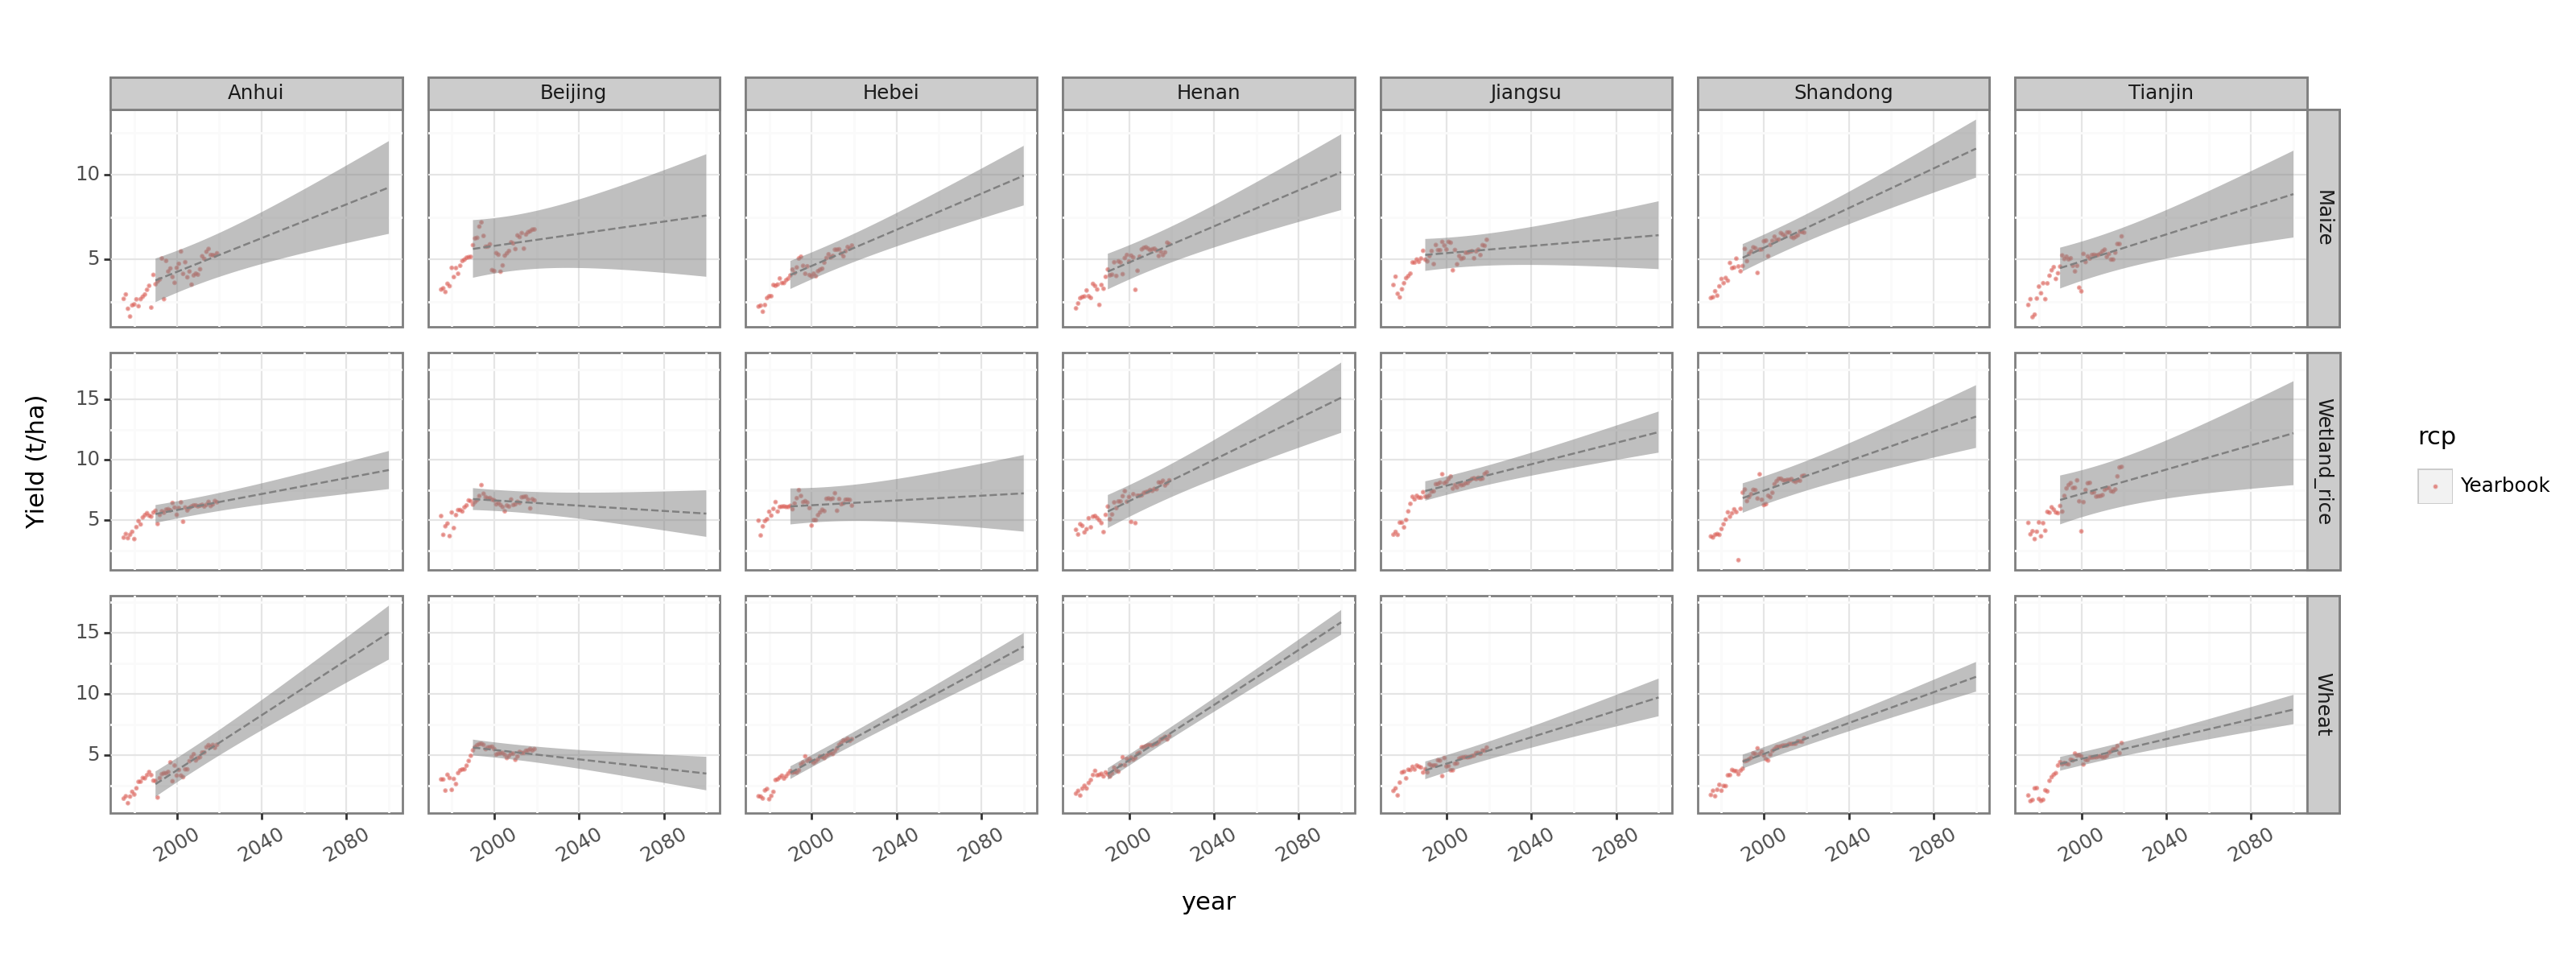

<Figure Size: (1600 x 600)>

In [23]:
# plot the trend of yearbook_yield_subtract_climate_impact
plotnine.options.figure_size = (16, 6)
plotnine.options.dpi = 100

g = (ggplot() +
#  geom_line(GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul, aes('year','Mean Production',group='rcp'),alpha=0.3,color='grey') +
#  geom_ribbon(GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul, aes(x='year',ymax='top',ymin='bot',group='rcp'),alpha=0.1,fill='grey') +
 geom_point(crop_yield_history_1975_2020, aes('year','Mean Production',color='rcp'),alpha=0.5,size=0.2) +
#  geom_line(GYGA_weighted_by_area_ratio, aes('year','Mean Production',color='rcp'),size=2) +
#  geom_line(GAEZ_actual_forced_with_Yearbook_weighted_mean_for_plot, aes('year','Mean Production',color='rcp'),size=1.5,alpha=0.7) +
#  geom_line(GAEZ_actual_yield_propogated_area_weighted_mean_df, aes('year','Mean Production',color='rcp')) +
#  geom_ribbon(GAEZ_actual_yield_propogated_area_weighted_mean_df, aes(x='year',ymax='top',ymin='bot',fill='rcp'),alpha=0.5) +
 geom_line(fit_df, aes('year','linear_fit'),color='grey',linetype='dashed') +
 geom_ribbon(fit_df, aes(x='year',ymax='obs_ci_upper',ymin='obs_ci_lower'),alpha=0.5,fill='grey') +
 facet_grid('crop~Province',scales='free') +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=30)) +
 ylab('Yield (t/ha)')
)

g

In [21]:
g.save('../Figs/fig_review_01_produtivity_improvement.svg')

C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 16 x 6 in image.
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../Figs/fig_review_01_produtivity_improvement.svg


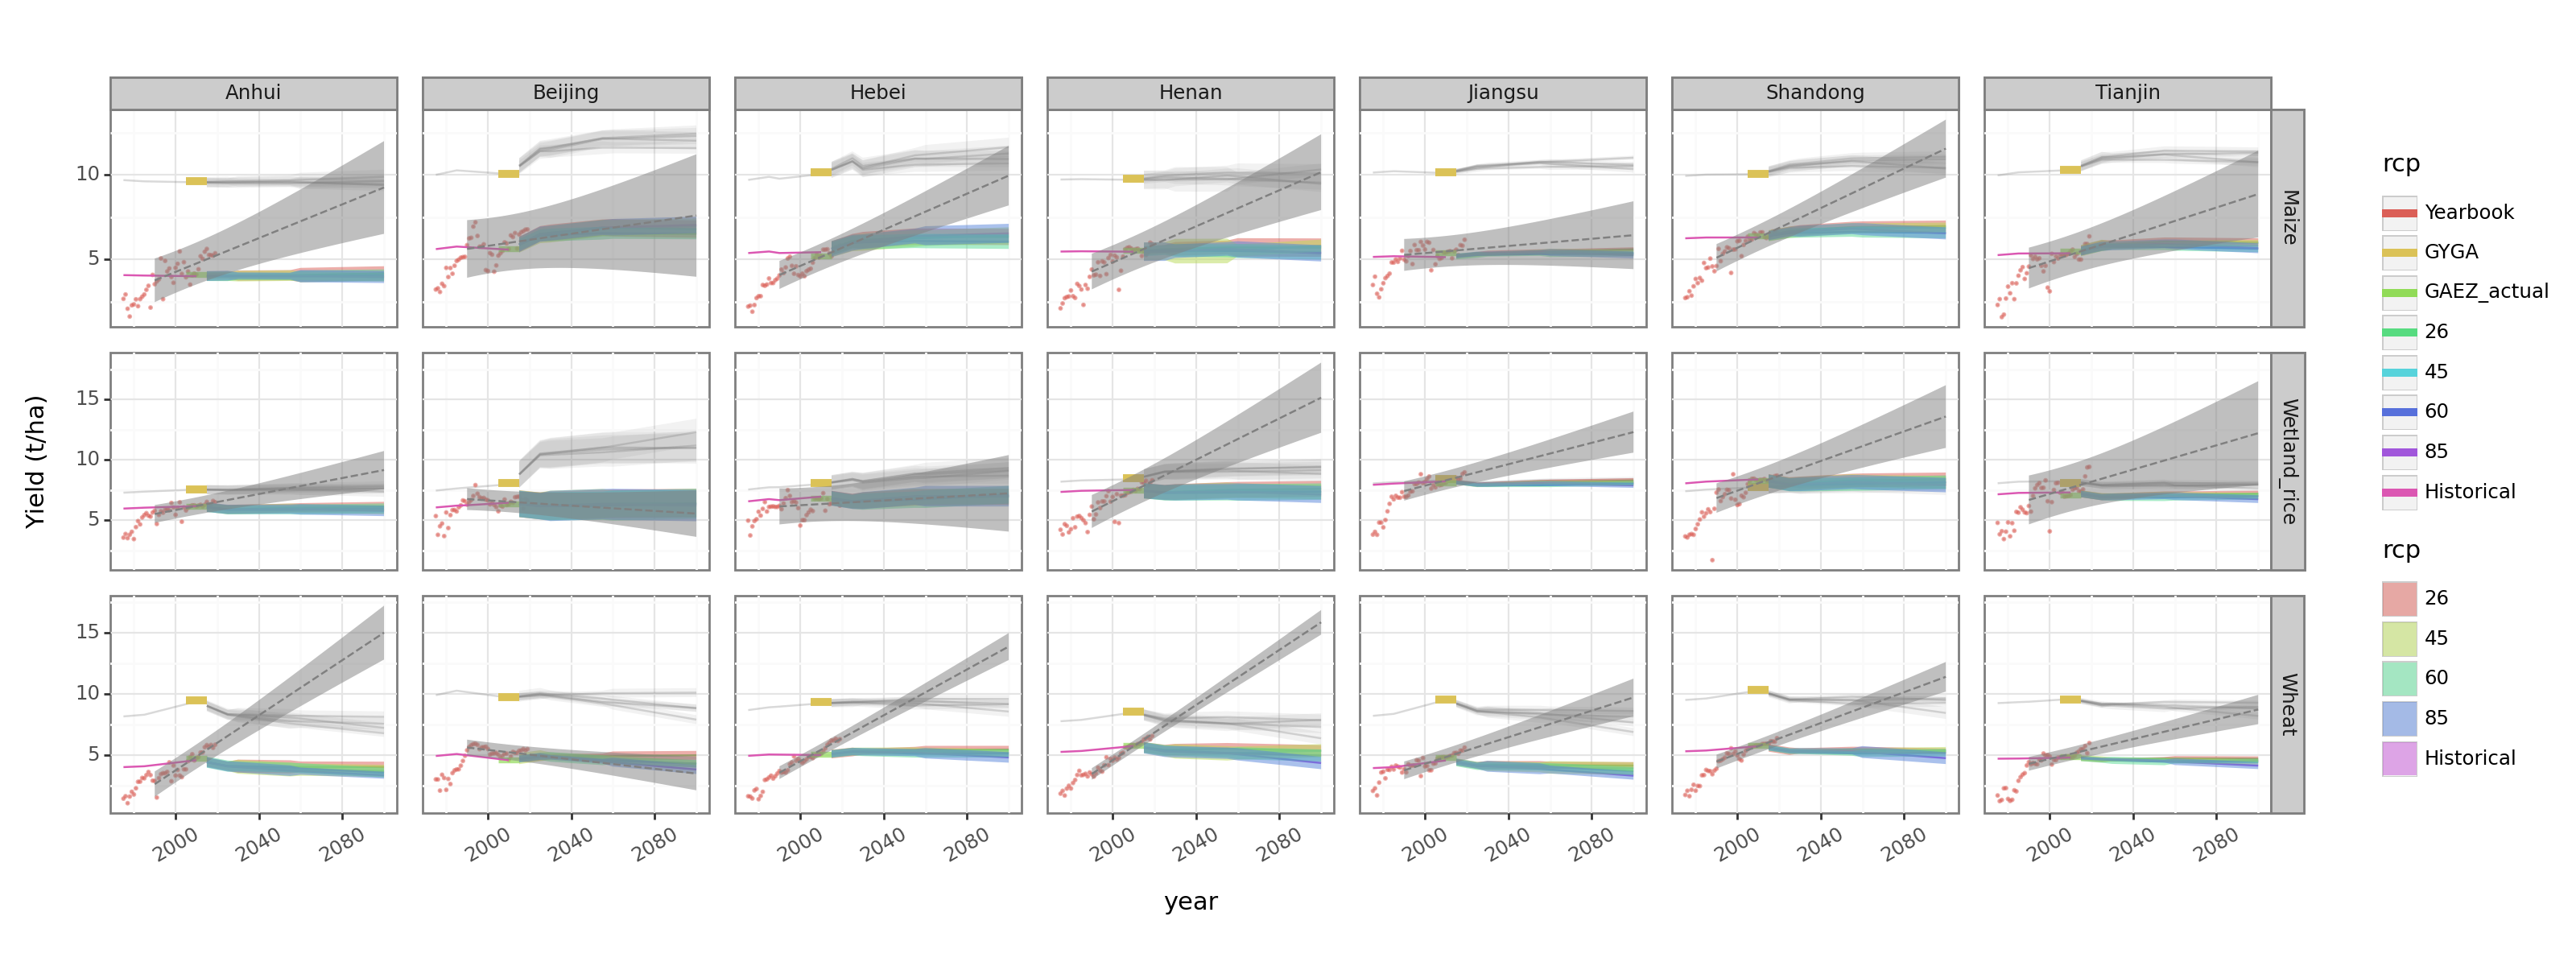

<Figure Size: (1600 x 600)>

In [24]:
# plot the trend of yearbook_yield_subtract_climate_impact
plotnine.options.figure_size = (16, 6)
plotnine.options.dpi = 100

(ggplot() +
 geom_line(GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul, aes('year','Mean Production',group='rcp'),alpha=0.3,color='grey') +
 geom_ribbon(GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul, aes(x='year',ymax='top',ymin='bot',group='rcp'),alpha=0.1,fill='grey') +
 geom_point(crop_yield_history_1975_2020, aes('year','Mean Production',color='rcp'),alpha=0.5,size=0.2) +
 geom_line(GYGA_weighted_by_area_ratio, aes('year','Mean Production',color='rcp'),size=2) +
 geom_line(GAEZ_actual_forced_with_Yearbook_weighted_mean_for_plot, aes('year','Mean Production',color='rcp'),size=1.5,alpha=0.7) +
 geom_line(GAEZ_actual_yield_propogated_area_weighted_mean_df, aes('year','Mean Production',color='rcp')) +
 geom_ribbon(GAEZ_actual_yield_propogated_area_weighted_mean_df, aes(x='year',ymax='top',ymin='bot',fill='rcp'),alpha=0.5) +
 geom_line(fit_df, aes('year','linear_fit'),color='grey',linetype='dashed') +
 geom_ribbon(fit_df, aes(x='year',ymax='obs_ci_upper',ymin='obs_ci_lower'),alpha=0.5,fill='grey') +
 facet_grid('crop~Province',scales='free') +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=30)) +
 ylab('Yield (t/ha)')
)

#### Add the yearbook_trend to GAEZ_actual_yield

In [25]:
# mannually set the slope less than 0 as 0
# because we assumes that the crop yield will not decrease in the future
yearbook_regression_parameter_df_1990 = parameter_df >> mask(X.start_year == 1990)
yearbook_regression_parameter_df_1990.loc[yearbook_regression_parameter_df_1990['linear_fit_a']<0,'linear_fit_a'] = 0

yearbook_regression_parameter_df_1990.to_csv('./result_csv/yearbook_regression_parameter_df_1990.csv',index=False)

In [28]:
# create the delta img for each province
delta_mosaics = {}
for idx,df in yearbook_regression_parameter_df_1990.groupby('crop'):
  province_delta_dict = zip(df['Province'],df['linear_fit_a'])

  shps = []
  for province,val in province_delta_dict:
    shp = NCP_provinces.filterMetadata('EN_Name','equals',province).first()
    shp = shp.set('crop',idx,'Name',province,'delta',val)
    shps.append(shp)

  fe_col = ee.FeatureCollection(shps)

  delta_mosaics[idx] = [ee.Image(0).toFloat().paint(featureCollection =fe_col,color='delta')]

# get the mosaiced imgs
delta_mosiac_img = pd.DataFrame(delta_mosaics).T.reset_index()
delta_mosiac_img.columns = ['crop','delta_img']

In [ ]:
# function to get mean yield for each province
def compute_yield_each_province(in_df):

  # hack to show progress bar
  print(' ',end='',flush=True)

  df_list = []

  # compute the attainable yield in each provinces
  for idx,row in tqdm(in_df.iterrows(),total=len(in_df)):
    crop = row['crop']
    year = row['year']
    rcp = row['rcp']

    img_val = row['img_val'].toFloat()
    img_ds = row['img_sd'].toFloat()
    img = ee.Image([img_val,img_ds]).rename(['val','sd'])

    # compute stats from GEE
    stats = img.reduceRegions(collection=NCP_provinces,reducer='mean',scale=GAEZ_pix_scale).getInfo()

    # get data
    stats_df = pd.DataFrame({i['properties']['EN_Name']:[i['properties']['val']] for i in stats['features']}).T
    stats_df['sd'] = [i['properties']['sd'] for i in stats['features']] 

    # append infomation
    stats_df = stats_df.reset_index()
    stats_df.columns=['Province','Mean Production','sd']
    stats_df['crop'] = crop
    stats_df['year'] = year
    stats_df['rcp'] = rcp

    stats_df['top'] = stats_df['Mean Production'] + stats_df['sd']
    stats_df['bot'] = stats_df['Mean Production'] - stats_df['sd']
    
    # store df                        
    df_list.append(stats_df)

  # concat dfs
  out_df = pd.concat(df_list,ignore_index=True)
  
  return out_df

In [ ]:
def compute_area_weighted_mean(df):

  ##################### Multiply each crop_water with its area_ratio #############
  # read the harvested area ratio so we can compute the weigted mean attainable yield
  area_ratio = pd.read_pickle('./result_csv/harvested_area_ratio.pkl')
  df = df.merge(area_ratio,on=['crop','water'])

  # compute the area_weighted actual yield
  df['val_area_weighted'] = df.apply(lambda x:x['img_future_yield'].multiply(x['area_ratio']),1)
  df['sd_area_weighted'] = df.apply(lambda x:ee.Image(x['img_future_sd']).multiply(x['area_ratio']),1)

  ##################### Sum the area_weighted yield #############
  stats_dict = {}
  for idx,df in df.groupby(['crop','year','rcp']):

    img_val = ee.ImageCollection(df['val_area_weighted'].tolist()).sum()
    img_sd = ee.ImageCollection(df['sd_area_weighted'].tolist()).sum()

    stats_dict[idx] = {'img_val':img_val,"img_sd":img_sd}

  ##################### make the stats a sensibel df #############
  out_df = pd.DataFrame(stats_dict).T.reset_index()
  out_df = out_df.rename(columns={'level_0':'crop','level_1':'year','level_2':'rcp'})

  return out_df

In [ ]:
# filter the 2015-2100 records
GAEZ_actual_yield_2015_2100 = GAEZ_actual_yield_propogated >> mask(X.year>=2015)

# link GAEZ_propagated_yield with yearbook_trend_parameters
GAEZ_actual_link_Yearbook_trend = GAEZ_actual_yield_2015_2100.merge(delta_mosiac_img,on='crop')

# get the future yield by adding the delta_img*delta_year
GAEZ_actual_link_Yearbook_trend['img_future_yield'] = GAEZ_actual_link_Yearbook_trend.apply(lambda row:row['propogated_yield']
                                                        .add(row['delta_img'].multiply(row['year']-2010)),1)

# select only necessary colums
GAEZ_actual_link_Yearbook_trend = GAEZ_actual_link_Yearbook_trend >> drop(['propogated_yield','delta_img'])
GAEZ_actual_link_Yearbook_trend.to_pickle('./result_csv/GAEZ_actual_link_Yearbook_trend.pkl')

In [ ]:
# 1) first get area_weighted mean attainable yield (t/ha)
GAEZ_actual_link_Yearbook_trend_area_weighted_mean = compute_area_weighted_mean(GAEZ_actual_link_Yearbook_trend)

# 2) then get mean attainable yield (t/ha) in each province
GAEZ_actual_link_Yearbook_trend_area_weighted_mean_df = parallelize_dataframe(GAEZ_actual_link_Yearbook_trend_area_weighted_mean,compute_yield_each_province,50)
GAEZ_actual_link_Yearbook_trend_area_weighted_mean_df['rcp'] = GAEZ_actual_link_Yearbook_trend_area_weighted_mean_df['rcp'].astype('category')
GAEZ_actual_link_Yearbook_trend_area_weighted_mean_df.to_csv('./result_csv/GAEZ_actual_link_Yearbook_trend_area_weighted_mean_df.csv',index=False)

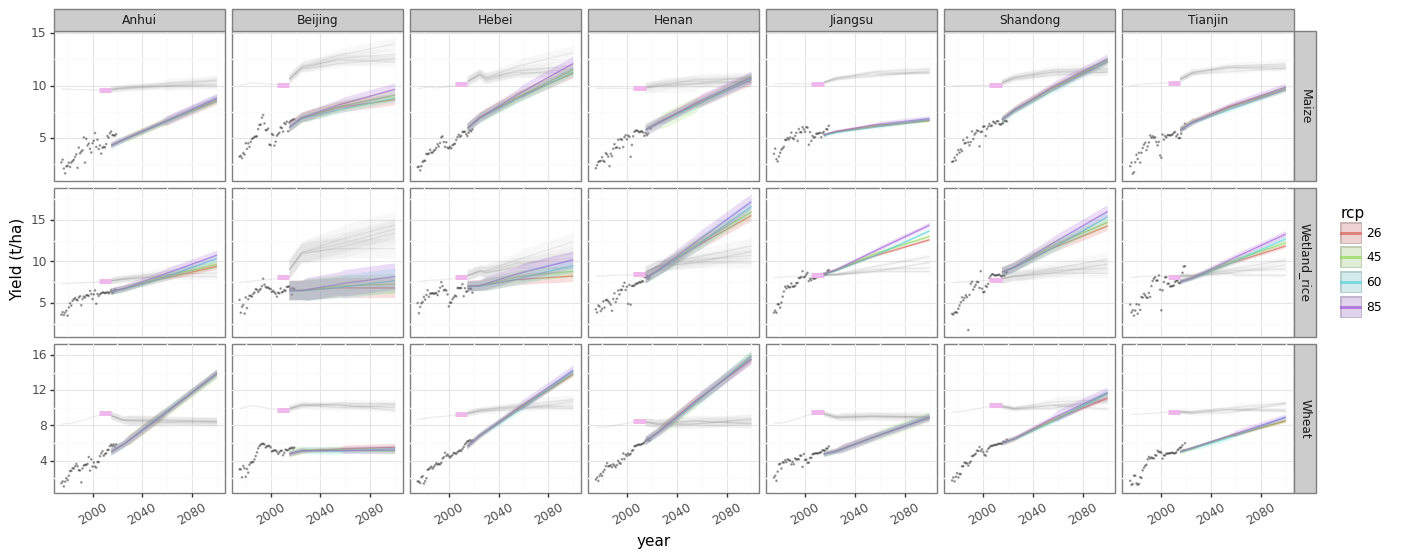

<ggplot: (8794098313201)>

In [ ]:
# plot the trend of yearbook_yield_subtract_climate_impact
plotnine.options.figure_size = (16, 6)
plotnine.options.dpi = 100

(ggplot() +
 # yearbook
 geom_point(crop_yield_history_1975_2020, aes('year','Mean Production'),size=0.1,alpha=0.3) +
 # GAEZ_attainable
 geom_line(GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul, 
           aes('year','Mean Production',group='rcp'),alpha=0.15,color='grey') +
 geom_ribbon(GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul, 
           aes(x='year',ymax='top',ymin='bot',group='rcp'),alpha=0.05,fill='grey') +
 # GYGA_2010
 geom_line(GYGA_weighted_by_area_ratio, aes('year','Mean Production'),size=2,color='#efb7ec') +
 # GAEZ_actual_final
 geom_line(GAEZ_actual_link_Yearbook_trend_area_weighted_mean_df, 
           aes('year','Mean Production',color='rcp'),size=0.5,alpha=0.7) +
 geom_ribbon(GAEZ_actual_link_Yearbook_trend_area_weighted_mean_df, 
           aes(x='year',ymax='top',ymin='bot',fill='rcp'),alpha=0.2) +
 facet_grid('crop~Province',scales='free') +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=30)) +
 ylab('Yield (t/ha)')
)

### Force the predicted_yield to agree with yearbook_yile

#### compute the delta between predicted_yield_2020 and yearbook_yile_2019

In [ ]:
# read yearbook records
yield_yearbook_2019 = crop_yield_history_1975_2020 >> mask(X.year == 2019) >> select(['crop','Province','year','Mean Production'])

# read pred records
yield_pred_2020_rcp = GAEZ_actual_link_Yearbook_trend_area_weighted_mean_df >> mask(X.year == 2020)
yield_pred_2020 = yield_pred_2020_rcp.groupby(['crop','Province','year']).mean().reset_index() >> select(['crop','Province','year','Mean Production'])

In [ ]:
# mrege to get the delta values
yield_delta = yield_yearbook_2019.merge(yield_pred_2020,on=['crop','Province'])
yield_delta['yearbook_pred_delta'] = yield_delta['Mean Production_x'] - yield_delta['Mean Production_y']
yield_delta = yield_delta >> select(['crop','Province','yearbook_pred_delta'])

yield_delta.head()

,crop,Province,yearbook_pred_delta
0,Wheat,Beijing,0.541615
1,Wheat,Tianjin,0.780679
2,Wheat,Hebei,0.071272
3,Wheat,Jiangsu,0.722281
4,Wheat,Anhui,0.416727


In [ ]:
# create the delta img for each province
delta_mosaics = {}
for idx,df in yield_delta.groupby('crop'):
  province_delta_dict = zip(df['Province'],df['yearbook_pred_delta'])

  shps = []
  for province,val in province_delta_dict:
    shp = NCP_provinces.filterMetadata('EN_Name','equals',province).first()
    shp = shp.set('crop',idx,'Name',province,'delta',val)
    shps.append(shp)

  fe_col = ee.FeatureCollection(shps)

  delta_mosaics[idx] = [ee.Image(0).toFloat().paint(featureCollection =fe_col,color='delta')]

# get the mosaiced imgs
delta_mosiac_img = pd.DataFrame(delta_mosaics).T.reset_index()
delta_mosiac_img.columns = ['crop','delta_img']

In [ ]:
# add the delta_img to GAEZ_actual_link_Yearbook_trend
GAEZ_actual_forced_with_Yearbook = GAEZ_actual_link_Yearbook_trend.merge(delta_mosiac_img,on='crop')
GAEZ_actual_forced_with_Yearbook['img_future_yield'] = GAEZ_actual_forced_with_Yearbook.apply(lambda row:row['img_future_yield'].add(row['delta_img']),1)

GAEZ_actual_forced_with_Yearbook = GAEZ_actual_forced_with_Yearbook.drop('delta_img',1)
GAEZ_actual_forced_with_Yearbook.to_pickle('./result_csv/GAEZ_actual_forced_with_Yearbook.pkl')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [ ]:
# 1) first get area_weighted mean attainable yield (t/ha)
GAEZ_actual_forced_with_Yearbook_area_weighted_mean = compute_area_weighted_mean(GAEZ_actual_forced_with_Yearbook)

# 2) then get mean attainable yield (t/ha) in each province
GAEZ_actual_forced_with_Yearbook_area_weighted_mean_df = parallelize_dataframe(GAEZ_actual_forced_with_Yearbook_area_weighted_mean,compute_yield_each_province,50)
GAEZ_actual_forced_with_Yearbook_area_weighted_mean_df['rcp'] = GAEZ_actual_forced_with_Yearbook_area_weighted_mean_df['rcp'].astype('category')
GAEZ_actual_forced_with_Yearbook_area_weighted_mean_df.to_csv('./result_csv/GAEZ_actual_forced_with_Yearbook_area_weighted_mean_df.csv',index=False)

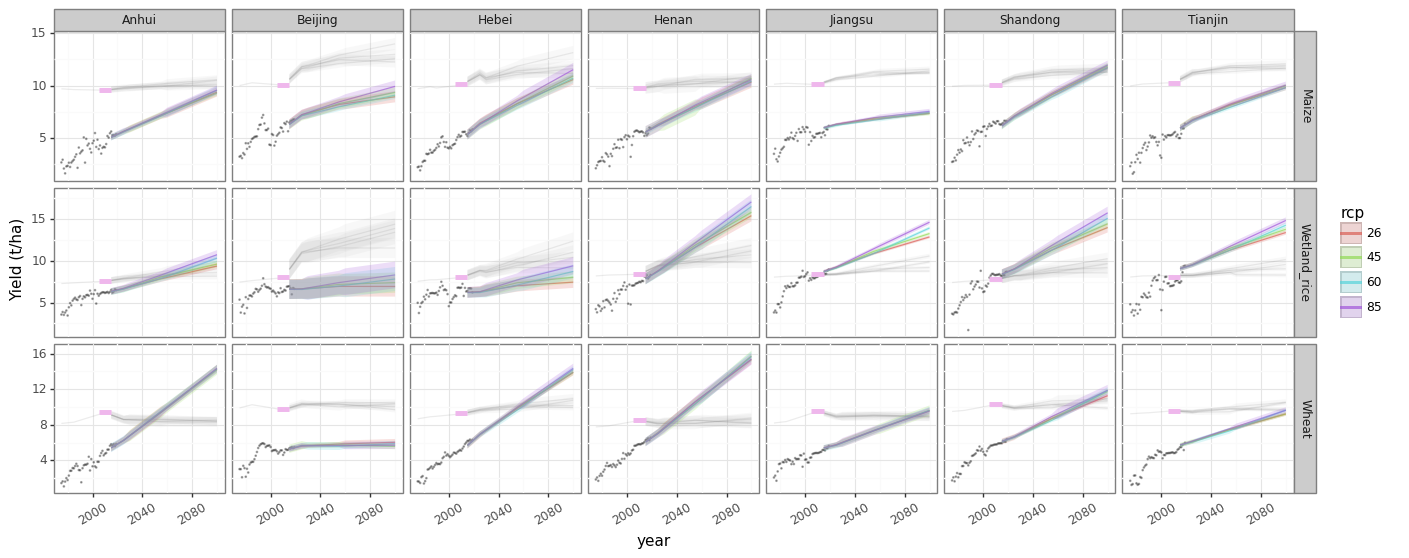

<ggplot: (8794092119457)>

In [ ]:
# plot the trend of yearbook_yield_subtract_climate_impact
plotnine.options.figure_size = (16, 6)
plotnine.options.dpi = 100

g = (ggplot() +
 # yearbook
 geom_point(crop_yield_history_1975_2020, aes('year','Mean Production'),size=0.1,alpha=0.3) +
 # GAEZ_attainable
 geom_line(GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul, 
           aes('year','Mean Production',group='rcp'),alpha=0.15,color='grey') +
 geom_ribbon(GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul, 
           aes(x='year',ymax='top',ymin='bot',group='rcp'),alpha=0.05,fill='grey') +
 # GYGA_2010
 geom_line(GYGA_weighted_by_area_ratio, aes('year','Mean Production'),size=2,color='#efb7ec') +
 # GAEZ_actual_final
 geom_line(GAEZ_actual_forced_with_Yearbook_area_weighted_mean_df, 
           aes('year','Mean Production',color='rcp'),size=0.5,alpha=0.7) +
 geom_ribbon(GAEZ_actual_forced_with_Yearbook_area_weighted_mean_df, 
           aes(x='year',ymax='top',ymin='bot',fill='rcp'),alpha=0.2) +
 facet_grid('crop~Province',scales='free') +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=30)) +
 ylab('Yield (t/ha)')
)

g

In [ ]:
g.save('../Figs//sup_17_GEAZ_actual_tech_extrapolatioin.svg')

/usr/local/lib/python3.7/dist-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 16 x 6 in image.
/usr/local/lib/python3.7/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /content/sup_17_GEAZ_actual_tech_extrapolatioin.svg
